# Using KGFE to understand important features

Basically, given a list of genes/proteins/metabolites that are mapped onto SPOKE, we want to identify nodes on the graph that are in some way "similar" to the input nodes.

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

## 1. Load genes

In [2]:
data = pd.read_excel('LC_mets_prots_V1_V2_Compare.xlsx')

In [3]:
data.head()

,ID,Lasso_CV,Name,UniProt,Protein,PubChem,Chembl_ID,KEGG
0,met10,-0.100203,"1,2,4-benzenetriol",NaN,NaN,10787.0,CHEMBL3092389,C02814
1,met1054,-0.052794,pyridine,NaN,NaN,1049.0,CHEMBL266158,C00747
2,met1073,0.051544,uric acid,NaN,NaN,1175.0,CHEMBL792,C00366
3,met1091,-0.054557,formononetin,NaN,NaN,5280378.0,CHEMBL242341,C00858
4,met142,0.025830,4-Hydroxyvalproic acid,NaN,NaN,134467.0,CHEMBL3706504,C16649


In [4]:
data.shape

(92, 8)

In [5]:
data[~data.Chembl_ID.isna()]

,ID,Lasso_CV,Name,UniProt,Protein,PubChem,Chembl_ID,KEGG
0,met10,-0.100203,"1,2,4-benzenetriol",NaN,NaN,10787.0,CHEMBL3092389,C02814
1,met1054,-0.052794,pyridine,NaN,NaN,1049.0,CHEMBL266158,C00747
2,met1073,0.051544,uric acid,NaN,NaN,1175.0,CHEMBL792,C00366
3,met1091,-0.054557,formononetin,NaN,NaN,5280378.0,CHEMBL242341,C00858
4,met142,0.025830,4-Hydroxyvalproic acid,NaN,NaN,134467.0,CHEMBL3706504,C16649
6,met20,-0.045657,"2,6-dihydroxybenzoic acid",NaN,NaN,9338.0,CHEMBL454808,NaN
11,met305,0.035464,hexadecanedioic acid,NaN,NaN,10459.0,CHEMBL4519590,C19615
12,met31,-0.057506,"3,5-dichlorosalicylic acid",NaN,NaN,9445.0,CHEMBL449129,NaN
15,met53,0.033875,benzyldodecyldimethylammonium,NaN,NaN,8754.0,CHEMBL1907001,NaN
18,met675,0.029451,cytidine,NaN,NaN,596.0,CHEMBL78,NaN


## 2. Load SPOKE

In [6]:
import igraph as ig

In [7]:
spoke_graph = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2023_human.json.gz', directed=True,
                                                    verbose=False)

In [8]:
spoke_graph_ud = spoke_graph.copy()
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')

In [9]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)

### Map proteins and metabolites to SPOKE nodes

In [10]:
len(names_to_ids)

596580

In [11]:
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein')

In [12]:
chembl_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Compound')

In [13]:
high_prots = data[(data['Lasso_CV'] > 0) & (~data['UniProt'].isna())]['UniProt']
low_prots = data[(data['Lasso_CV'] < 0) & (~data['UniProt'].isna())]['UniProt']
high_chems = data[(data['Lasso_CV'] > 0) & (~data['Chembl_ID'].isna())]['Chembl_ID']
low_chems = data[(data['Lasso_CV'] < 0) & (~data['Chembl_ID'].isna())]['Chembl_ID']

In [14]:
high_chems_kegg = data[(data['Lasso_CV'] > 0) & (~data['KEGG'].isna())]['KEGG']
low_chems_kegg = data[(data['Lasso_CV'] < 0) & (~data['KEGG'].isna())]['KEGG']

In [15]:
high_prots_spoke_ids = [uniprot_to_ids[x] for x in high_prots]
low_prots_spoke_ids = [uniprot_to_ids[x] for x in low_prots]

In [16]:
high_prots_spoke_ids[:10]

['10584',
 '10618',
 '10577',
 '14694',
 '3393',
 '479',
 '3332',
 '10685',
 '3508',
 '19496']

In [17]:
high_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in high_chems if  x in chembl_to_ids]
low_chems_spoke_ids = [(x, chembl_to_ids[x]) for x in low_chems if  x in chembl_to_ids]

Note: many chems were not able to be mapped onto SPOKE.

In [18]:
mapped_high_chem_ids = set([x[1] for x in high_chems_spoke_ids])
for c in high_chems_kegg:
    if c in chembl_to_ids:
        index = chembl_to_ids[c]
        if index not in mapped_high_chem_ids:
            high_chems_spoke_ids.append((c, index))
mapped_low_chem_ids = set([x[1] for x in low_chems_spoke_ids])
for c in low_chems_kegg:
    if c in chembl_to_ids:
        index = chembl_to_ids[c]
        if index not in mapped_low_chem_ids:
            low_chems_spoke_ids.append((c, index))

In [19]:
high_chems_spoke_ids

[('CHEMBL792', '523510'),
 ('CHEMBL3706504', '535189'),
 ('CHEMBL78', '173395'),
 ('CHEMBL1162484', '525160'),
 ('CHEMBL1236395', '524231'),
 ('CHEMBL8165', '521673'),
 ('CHEMBL1226', '516414'),
 ('C01432', '541336'),
 ('C00077', '541403'),
 ('C00188', '541494'),
 ('C01083', '541636')]

In [20]:
low_chems_spoke_ids

[('CHEMBL3092389', '534667'),
 ('CHEMBL266158', '524340'),
 ('CHEMBL242341', '520625'),
 ('CHEMBL454808', '523091'),
 ('CHEMBL449129', '523116'),
 ('CHEMBL228057', '519122'),
 ('CHEMBL366563', '534527'),
 ('CHEMBL1256480', '523670'),
 ('CHEMBL394875', '535751'),
 ('C01152', '541242'),
 ('C01420', '541267'),
 ('C05123', '543887')]

### Compare the identified nodes against a null model.

In [21]:
spoke_graph_ud_connected = spoke_graph_ud.subcomponent(high_prots_spoke_ids[0])
spoke_graph_ud_connected = spoke_graph_ud.induced_subgraph(spoke_graph_ud_connected)

In [22]:
len(high_prots_spoke_ids)

31

In [23]:
len(low_prots_spoke_ids)

23

In [24]:
high_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, high_prots_spoke_ids)

In [25]:
%time high_prots_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(high_prots_spoke_ids))

CPU times: user 3min 49s, sys: 6.39 s, total: 3min 56s
Wall time: 3min 55s


In [26]:
%time low_prots_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein', len(low_prots_spoke_ids))

CPU times: user 2min 45s, sys: 6.18 s, total: 2min 51s
Wall time: 2min 51s


In [27]:
%time high_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, high_prots_spoke_ids)

CPU times: user 773 ms, sys: 40 ms, total: 813 ms
Wall time: 810 ms


In [28]:
%time low_prots_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, low_prots_spoke_ids)

CPU times: user 103 ms, sys: 87 µs, total: 103 ms
Wall time: 103 ms


In [29]:
high_prots_null_results = pd.DataFrame(high_prots_null_results)
low_prots_null_results = pd.DataFrame(low_prots_null_results)


In [30]:
high_prots_null_results.mean()

average_pairwise_distance      2.565140
degree_mean                  182.840323
degree_std                   221.205996
clustering                     0.279769
dtype: float64

In [31]:
low_prots_null_results.mean()

average_pairwise_distance      2.529526
degree_mean                  195.089130
degree_std                   249.038645
clustering                     0.283317
dtype: float64

In [32]:
import matplotlib.pyplot as plt

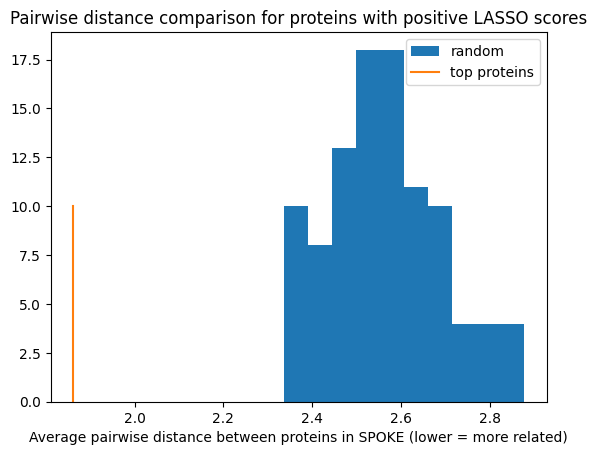

In [33]:
plt.hist(high_prots_null_results.average_pairwise_distance, bins=10, label='random')
plt.plot([high_prots_stats['average_pairwise_distance'], high_prots_stats['average_pairwise_distance']], [0, 10], label='top proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.title('Pairwise distance comparison for proteins with positive LASSO scores')
plt.legend()

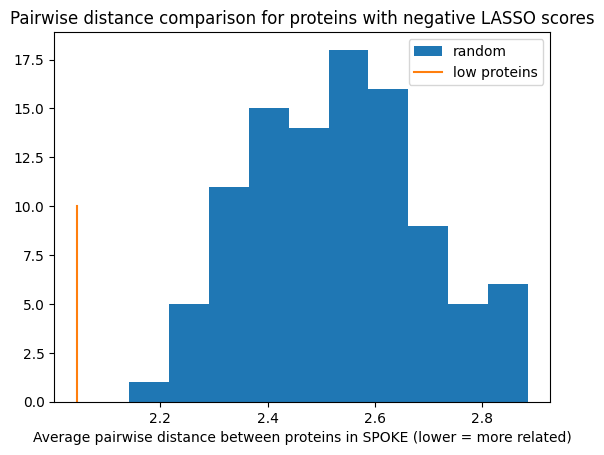

In [34]:
plt.hist(low_prots_null_results.average_pairwise_distance, bins=10, label='random')
plt.plot([low_prots_stats['average_pairwise_distance'], low_prots_stats['average_pairwise_distance']], [0, 10], label='low proteins')
plt.xlabel('Average pairwise distance between proteins in SPOKE (lower = more related)')
plt.title('Pairwise distance comparison for proteins with negative LASSO scores')
plt.legend()

In [35]:
%time high_chems_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Compound', len(high_chems_spoke_ids))

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


In [36]:
%time low_chems_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Compound', len(low_chems_spoke_ids))

CPU times: user 1min 7s, sys: 5.83 s, total: 1min 13s
Wall time: 1min 13s


In [37]:
%time high_chems_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, [x[1] for x in high_chems_spoke_ids])

CPU times: user 562 ms, sys: 0 ns, total: 562 ms
Wall time: 560 ms


In [38]:
%time low_chems_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected, [x[1] for x in low_chems_spoke_ids])

CPU times: user 1.94 s, sys: 7.89 ms, total: 1.94 s
Wall time: 1.94 s


In [75]:
high_chems_null_results = pd.DataFrame(high_chems_null_results)
low_chems_null_results = pd.DataFrame(low_chems_null_results)

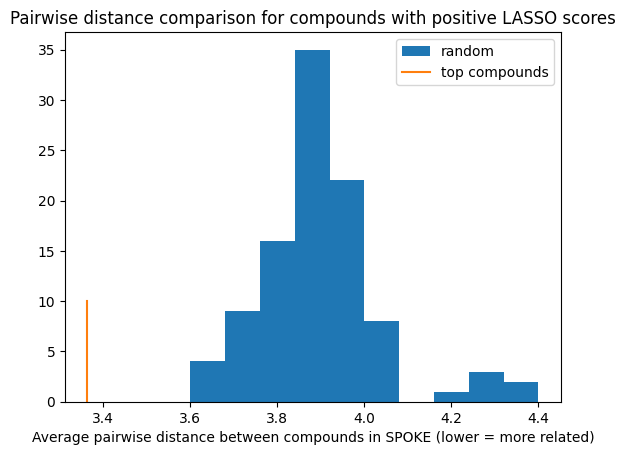

In [76]:
plt.hist(high_chems_null_results.average_pairwise_distance, bins=10, label='random')
plt.plot([high_chems_stats['average_pairwise_distance'], high_chems_stats['average_pairwise_distance']], [0, 10], label='top compounds')
plt.xlabel('Average pairwise distance between compounds in SPOKE (lower = more related)')
plt.title('Pairwise distance comparison for compounds with positive LASSO scores')
plt.legend()

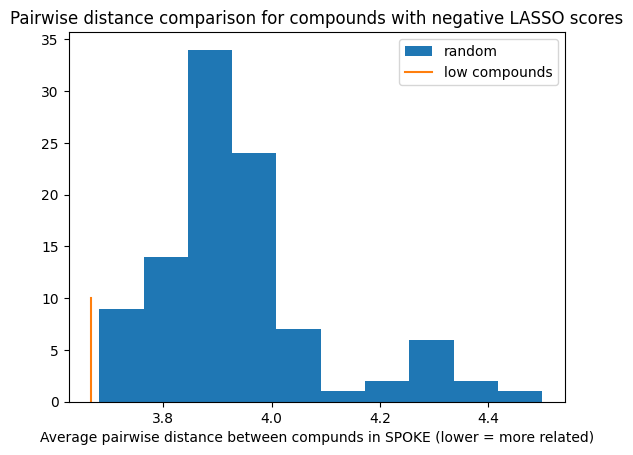

In [77]:
plt.hist(low_chems_null_results.average_pairwise_distance, bins=10, label='random')
plt.plot([low_chems_stats['average_pairwise_distance'], low_chems_stats['average_pairwise_distance']], [0, 10], label='low compounds')
plt.xlabel('Average pairwise distance between compunds in SPOKE (lower = more related)')
plt.title('Pairwise distance comparison for compounds with negative LASSO scores')
plt.legend()

## 3. Run topic PageRank

In [39]:
high_prots_pr_results, high_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, high_prots_spoke_ids)

In [40]:
low_prots_pr_results, low_prots_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, low_prots_spoke_ids)

In [41]:
high_chems_pr_results, high_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in high_chems_spoke_ids])

In [42]:
low_chems_pr_results, low_chems_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud, [x[1] for x in low_chems_spoke_ids])

In [43]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

## 4. Plot PageRank results

In [44]:
import matplotlib.pyplot as plt

### Proteins with positive Lasso_CV scores

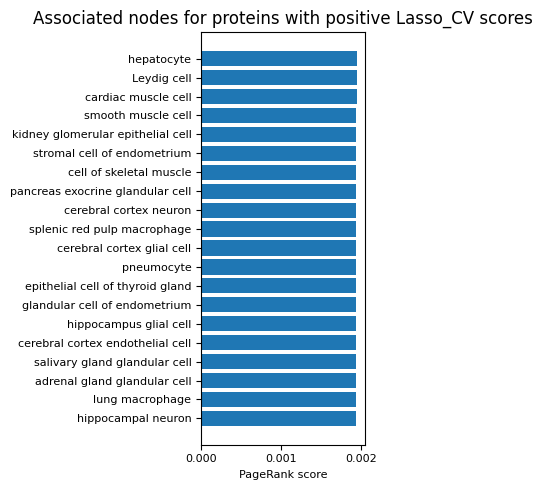

In [45]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_nodes[:20][::-1]], [x['score'] for x in high_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

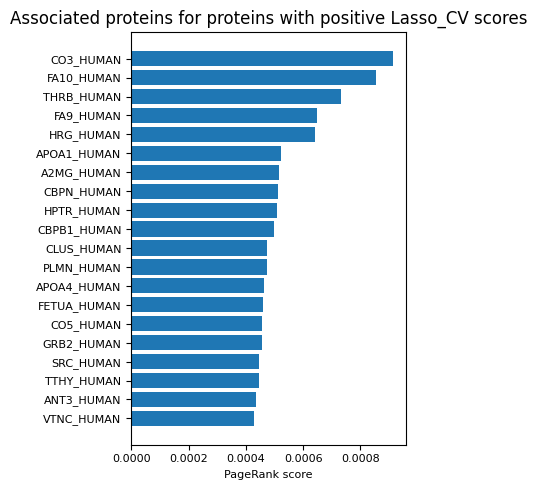

In [46]:
high_prots_top_proteins = [x for x in high_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

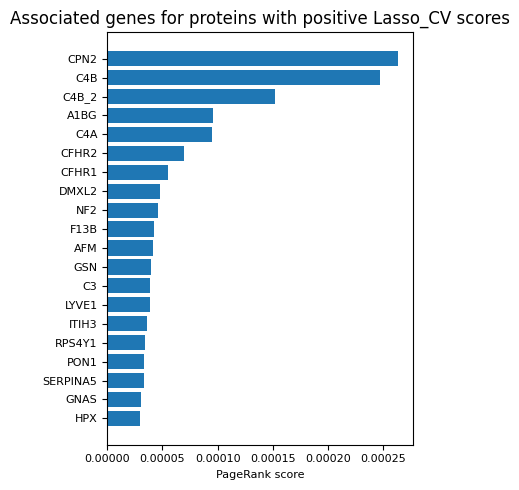

In [47]:
high_prots_top_genes = [x for x in high_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_genes[:20][::-1]], [x['score'] for x in high_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Proteins with negative Lasso_CV scores

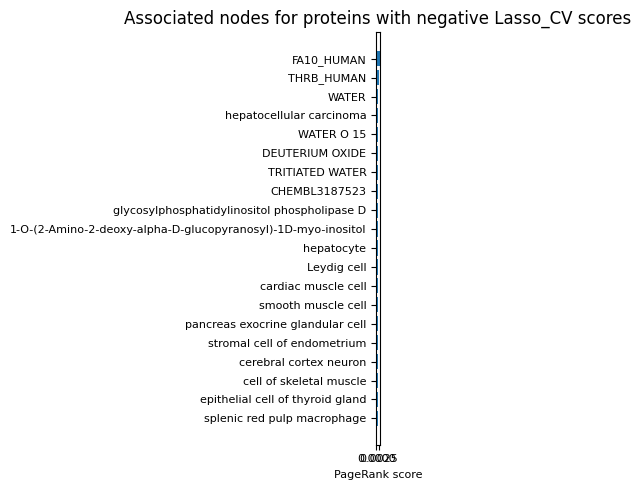

In [48]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_nodes[:20][::-1]], [x['score'] for x in low_prots_top_nodes[:20][::-1]], )
plt.title('Associated nodes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

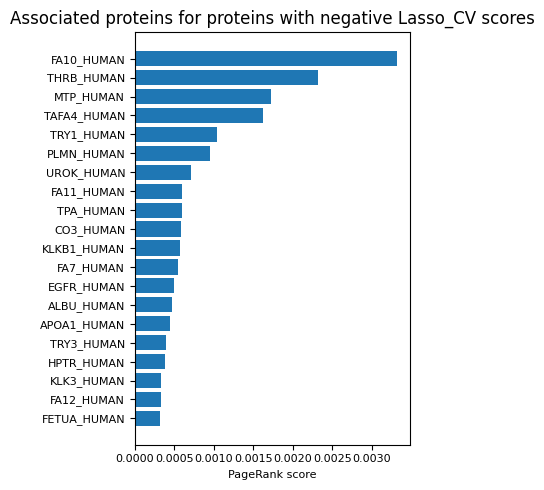

In [49]:
low_prots_top_proteins = [x for x in low_prots_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_proteins[:20][::-1]], [x['score'] for x in low_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

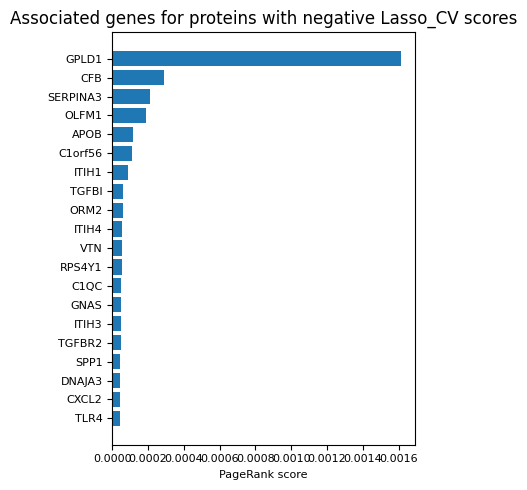

In [50]:
low_prots_top_genes = [x for x in low_prots_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_prots_top_genes[:20][::-1]], [x['score'] for x in low_prots_top_genes[:20][::-1]], )
plt.title('Associated genes for proteins with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with positive Lasso_CV scores

/tmp/ipykernel_272233/2546614946.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


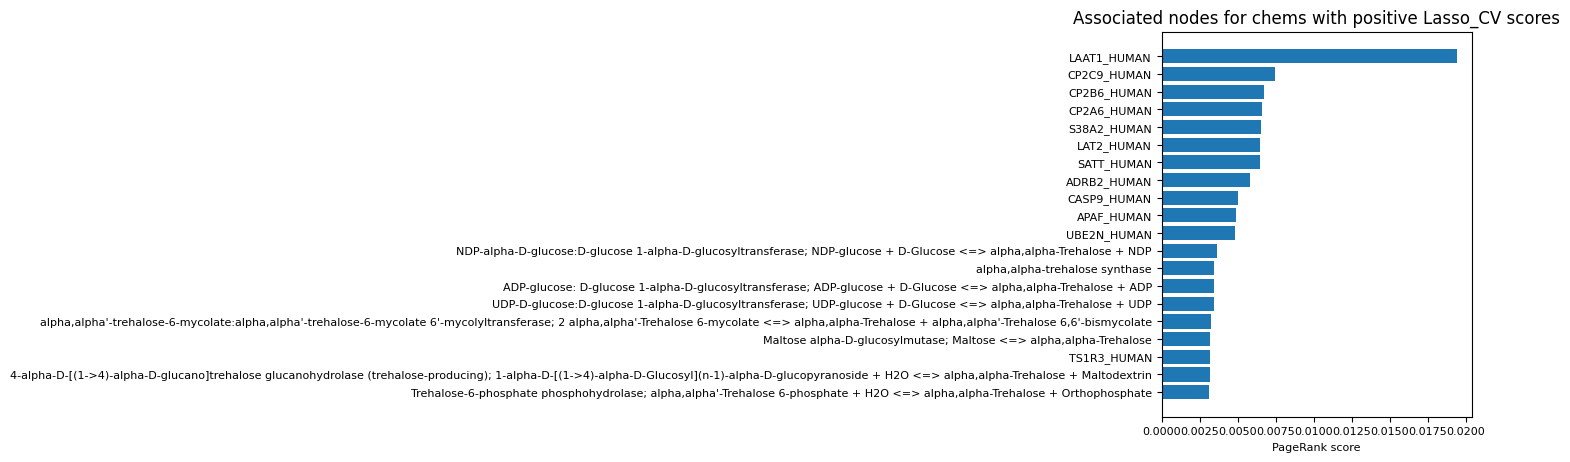

In [51]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_nodes[:20][::-1]], [x['score'] for x in high_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

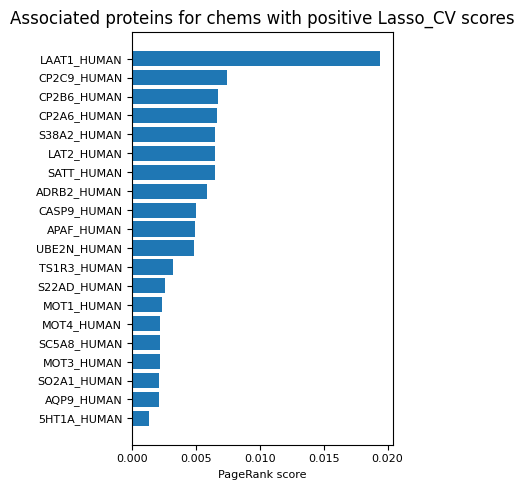

In [52]:
high_chems_top_proteins = [x for x in high_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_proteins[:20][::-1]], [x['score'] for x in high_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

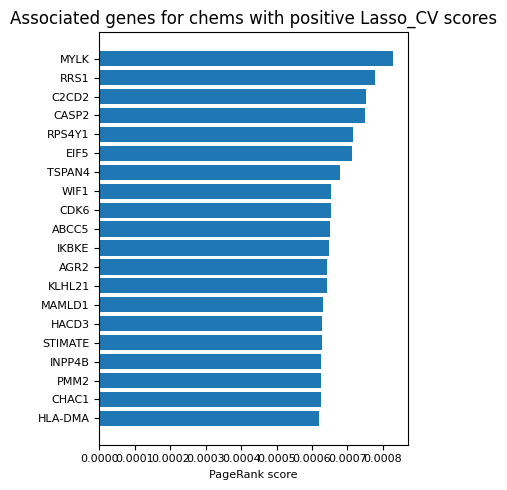

In [53]:
high_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_genes[:20][::-1]], [x['score'] for x in high_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

/tmp/ipykernel_272233/1194101335.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


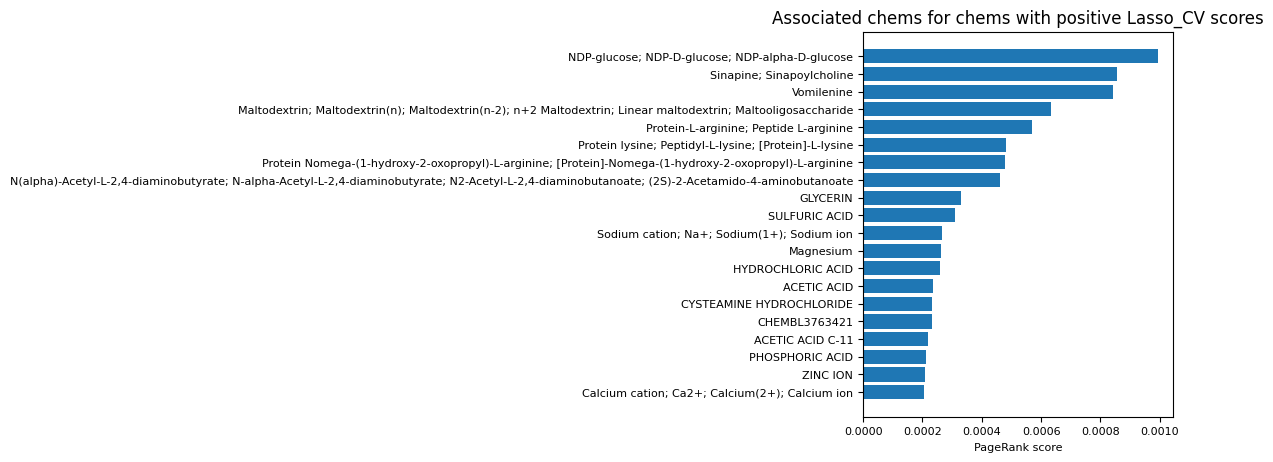

In [54]:
high_chems_top_chems = [x for x in high_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_chems_top_chems[:20][::-1]], [x['score'] for x in high_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with positive Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

### Chems with negative Lasso_CV scores

/tmp/ipykernel_272233/3090059252.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


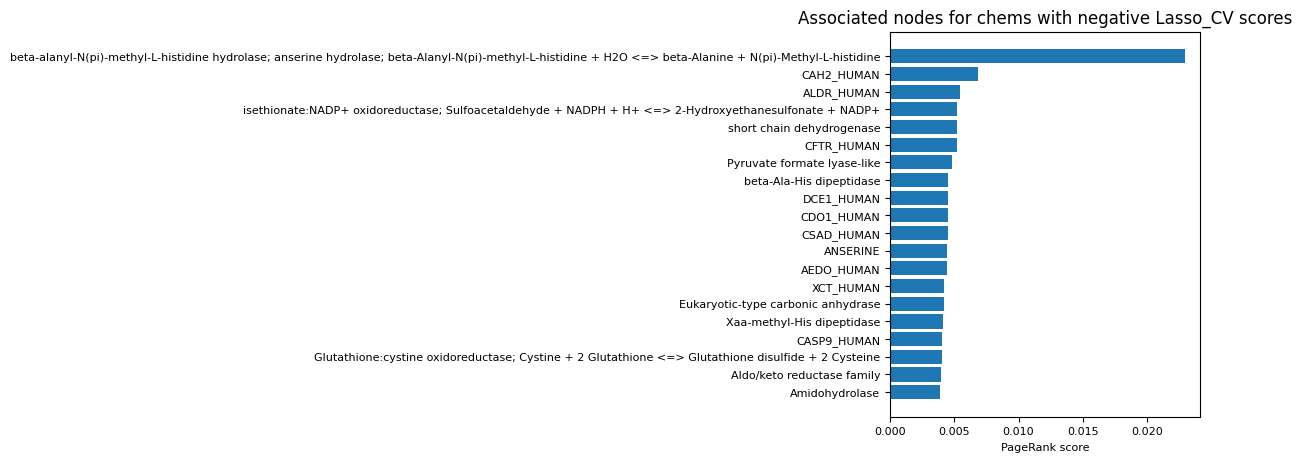

In [55]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_nodes[:20][::-1]], [x['score'] for x in low_chems_top_nodes[:20][::-1]], )
plt.title('Associated nodes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

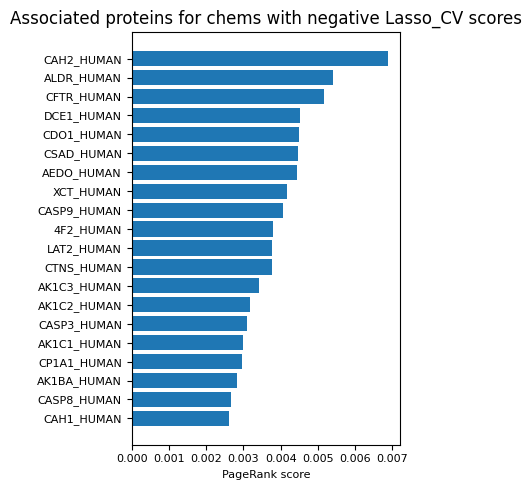

In [56]:
low_chems_top_proteins = [x for x in low_chems_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_proteins[:20][::-1]], [x['score'] for x in low_chems_top_proteins[:20][::-1]], )
plt.title('Associated proteins for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

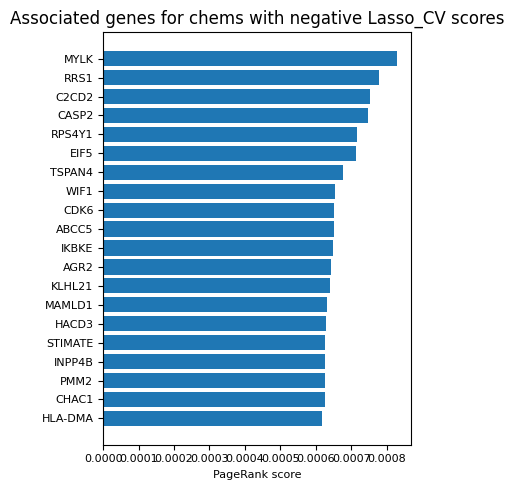

In [57]:
low_chems_top_genes = [x for x in high_chems_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_genes[:20][::-1]], [x['score'] for x in low_chems_top_genes[:20][::-1]], )
plt.title('Associated genes for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

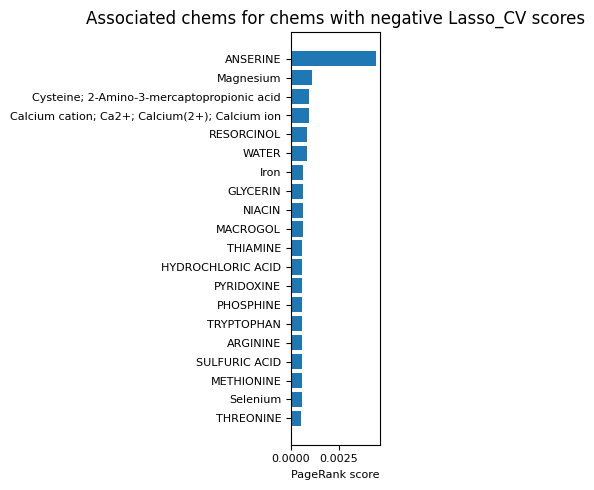

In [58]:
low_chems_top_chems = [x for x in low_chems_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in low_chems_top_chems[:20][::-1]], [x['score'] for x in low_chems_top_chems[:20][::-1]], )
plt.title('Associated chems for chems with negative Lasso_CV scores')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

## 5. Get Steiner trees / subgraphs

In [59]:
high_protein_st, high_protein_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                                 high_prots_spoke_ids,
                                                                                 method='takahashi')

In [60]:
low_protein_st, low_protein_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                              low_prots_spoke_ids,
                                                                              method='takahashi')

In [61]:
# TODO: get a connected component from the first chem?

In [62]:
high_chems_st, high_chems_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                            [x[1] for x in high_chems_spoke_ids],
                                                                            method='takahashi')

In [63]:
low_chems_st, low_chems_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud,
                                                                          [x[1] for x in low_chems_spoke_ids],
                                                                          method='takahashi')

## Visualizing subgraphs

In [64]:
import ipycytoscape

In [65]:
# TODO: display the node category somewhere, and display the edge categories
graph_style = [{
                        'selector': 'node[feature_name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'label': 'data(feature_name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                        {'selector': 'node[in_query=1]',
                         'style': {
                             'border-width': '5px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[type]',
                         'style': {
                             'label': 'data(type)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

In [66]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = high_protein_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

In [67]:
display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [68]:
low_prots_graph = ipycytoscape.CytoscapeWidget()
low_protein_subgraph_nx = low_protein_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in low_protein_subgraph_nx.nodes.items()}
low_protein_subgraph_nx = nx.relabel_nodes(low_protein_subgraph_nx, node_dict)
low_prots_graph.graph.add_graph_from_networkx(low_protein_subgraph_nx)
low_prots_graph.set_tooltip_source('name')
low_prots_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_prots_graph.set_style(graph_style)

In [69]:
display(low_prots_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [70]:
high_chems_graph = ipycytoscape.CytoscapeWidget()
high_chems_subgraph_nx = high_chems_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_chems_subgraph_nx.nodes.items()}
high_chems_subgraph_nx = nx.relabel_nodes(high_chems_subgraph_nx, node_dict)
high_chems_graph.graph.add_graph_from_networkx(high_chems_subgraph_nx)
high_chems_graph.set_tooltip_source('name')
high_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
high_chems_graph.set_style(graph_style)

In [71]:
display(high_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…

In [72]:
low_chems_graph = ipycytoscape.CytoscapeWidget()
low_chems_subgraph_nx = low_chems_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in low_chems_subgraph_nx.nodes.items()}
low_chems_subgraph_nx = nx.relabel_nodes(low_chems_subgraph_nx, node_dict)
low_chems_graph.graph.add_graph_from_networkx(low_chems_subgraph_nx)
low_chems_graph.set_tooltip_source('name')
low_chems_graph.set_layout(nodeSpacing=80, edgeLengthVal=50)
low_chems_graph.set_style(graph_style)

In [73]:
display(low_chems_graph)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cytoscape_style=[{'…